In [1]:
%reset-f
%load_ext autoreload
%autoreload 2

import pandas as pd
from res_ind_lib import *
import pyDOE as doe

import matplotlib.pyplot as plt
%matplotlib inline

### Mumbai central case and policies

In [2]:
##Reads data
expost_=pd.read_csv("inputs/expost_studies.csv",index_col="place")

#fills the altnerative lines with default values
expost = expost_.fillna( value=expost_.ix["Mumbai"],axis=0)

#dummy "ref" dimensions (for the derivatives)
expost = def_ref_values(expost,kind="expost")


#Computes resilience
ep=compute_resiliences(expost,kind="expost")

#Report
ep[expost_.columns]=expost_
ep.to_csv("results/expost_studies_with_results.csv")
cost_metrics = ["total_equivalent_cost","dKtot"]
ep[cost_metrics]

,total_equivalent_cost,dKtot
place,,
Mumbai,5.297356e+10,3.455702e+10
fa_.95,5.032390e+10,3.282917e+10
v_.95,5.025409e+10,3.282917e+10
double_sigma,4.777081e+10,3.455702e+10
rebuild_one_third,5.102786e+10,3.455702e+10
double_social,4.833338e+10,3.455702e+10
halve_pv,4.982089e+10,3.455702e+10
double_banks,5.280395e+10,3.455702e+10
share1_ten_percent,5.127836e+10,3.494305e+10


###Sensitivity analysis

####data

In [5]:
print("All columns\n", pd.read_csv("inputs/expost_studies.csv").columns.values)

#dimensions that will be varied
uncertain_dims = ['share1', 'shew', 'plgp', 'unemp',
       'axfin_p', 'axfin_r', 'axhealth', 'social_p', 'social_r',
       'pov_head', 'avg_prod_k', 'fa', 'pe', 'H', 'alpha', 'T_rebuild_K',
       'T_rebuild_L', 'pi',  'v', 'pv', 'sigma_p',
       'sigma_r', 'share_nat_income'] 

#other_dims = np.setdiff1d(expost.columns,uncertain_dims).tolist()

#Describers for the paper
uncertain_dims_described = pd.read_csv("inputs/inputs_info.csv",index_col="key", usecols=["key","descriptor"], squeeze=True)[uncertain_dims].dropna().tolist()
print("\nnumber of uncertain factors:", len(uncertain_dims_described))
print("; ".join(uncertain_dims_described))

#Design Of Experiment
n=len(uncertain_dims)
var = 1/3

#mutipliers between 1-var and 1+var
print("\nDesigning experiement (DOE)...")
aleas = 1+(2*var * pd.DataFrame(doe.lhs(n,samples=2200,criterion="corr"),columns=uncertain_dims) -var)
aleas.head()

All columns
 ['place' 'gdp_pc_pp' 'pop' 'share1' 'shew' 'plgp' 'unemp' 'axfin_p'
 'axfin_r' 'axhealth' 'social_p' 'social_r' 'iso3' 'pov_head' 'avg_prod_k'
 'fa' 'pe' 'H' 'alpha' 'T_rebuild_K' 'T_rebuild_L' 'pi' 'income_elast' 'v'
 'pv' 'sigma_p' 'sigma_r' 'share_nat_income']

number of uncertain factors: 22
Income share of bottom quintile; Access to early warning; Basic education; Unemployment; Access to finance for poor people; Access to finance for non-poor people; Access to health care; Social protection for poor people; Social protection for non-poor people; Poverty headcount; Productivity of capital; Exposure; Exposure bias; Homogeneity of damages; Ripple effects; Time to reconstruct; Time to rebuild human capital; Avoided losses with early warning; Vulnerability without early warning; Asset-vulnerability bias; Risk sharing for poor people; Risk sharing for non-poor people

Designing experiement (DOE)...
new candidate solution found with max,abs corrcoef = 0.8789719267034652
new 

,share1,shew,plgp,unemp,axfin_p,axfin_r,axhealth,social_p,social_r,pov_head,...,H,alpha,T_rebuild_K,T_rebuild_L,pi,v,pv,sigma_p,sigma_r,share_nat_income
0,1.237736,1.028551,0.947130,0.714437,0.964672,1.241980,0.948432,0.829385,0.705675,1.013185,...,0.806292,0.772256,0.701561,0.892771,1.183201,0.872495,1.070655,0.979004,0.893475,0.677400
1,1.036211,0.901636,0.891094,0.908705,1.021989,1.257070,0.834402,0.775260,1.082751,0.855877,...,1.077732,1.246165,1.026856,1.185944,0.940139,1.078666,1.088525,1.327607,0.668006,1.002753
2,1.021382,0.700394,0.874903,1.228130,0.745184,0.805659,1.126777,0.993360,0.895386,1.024386,...,1.148101,0.691234,1.167192,1.229815,1.203346,0.775420,1.007728,0.728421,0.836564,0.753126
3,1.095282,0.777340,1.222593,1.030541,0.695072,1.014897,0.903990,0.881284,1.076402,0.895180,...,0.911569,1.115261,1.267923,1.133225,0.822077,1.047042,0.718872,0.940710,0.674357,0.989350
4,0.743376,0.724963,0.734045,0.689440,0.805201,1.312110,0.745890,1.045644,1.010287,0.756623,...,1.283438,1.056371,0.893048,1.260545,0.882050,1.195855,1.161076,0.858485,1.295181,0.972140


####function

In [6]:
#shortcuts
mumbai   = expost.ix[["Mumbai"]]
policies = expost.drop("Mumbai")

def compute_sensiv(aleas):
    sensiv = pd.DataFrame(index=aleas.index, columns=pd.MultiIndex.from_product([policies.index,cost_metrics],names=["policy","metric"]))

    for i in policies.index:
        #appends aleas to ref case
        ref = mumbai.append(aleas*mumbai[aleas.columns].transpose().squeeze()).fillna(method="pad")
        #adds vs, fare, etc.
        ref = def_ref_values(ref)
        #computes resiliences
        ref=compute_resiliences(ref,kind="expost").drop("iso3",axis=1)

        #appends alea
        pol = policies.ix[[i]].append(aleas*policies.ix[i,aleas.columns].transpose().squeeze()).fillna(method="pad")
        #ref values
        pol = def_ref_values(pol)
        #resil
        pol = compute_resiliences(pol,kind="expost").drop("iso3",axis=1)

        #result change in percentage    
        res = 100 * (pol-ref)[cost_metrics].dropna() / ref[cost_metrics]
        sensiv[i]=res.dropna()

    #clean numerical errors
    sensiv[abs(sensiv)<1e-4]=0
        
    return sensiv

####actual computing

In [7]:
sensiv=compute_sensiv(aleas)

alea_eta =pd.DataFrame([2/3,1,4/3],columns=["income_elast"])
sensiv_eta = compute_sensiv(alea_eta)

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\generic.py:3800: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  return_indexers=True)


###Plots

In [8]:
#plot settings

font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 18}

plt.rc('font', **font)

plt.rcParams["legend.fancybox"]=True

#oranges
col_a="#fdbb84"
col_b="#e34a33"

#blues
col_c="#74a9cf"
col_d="#0570b0"

#fdbb84
#e34a33

In [12]:
def autolabel(ax,rects,color):
    # attach some data labels
    for rect in rects:
        y = rect.get_y()
        h = rect.get_height()
        height = y if y<0 else h
        ax.text(rect.get_x()+rect.get_width()/2.,
                height+np.sign(height)*.2,
                ' %1.1f'%(height),
                ha='left', va='top' if y<0 else 'bottom', color=color )

        
#Policy Labels (x axis)
policy_descriptions= pd.read_csv("inputs/policy_descriptions.csv",index_col=0,squeeze=True).str.replace('\r\n','\n')


#plots sensitivity analysis (in a function to plot separatedly the effect of eta)
def plot_sensiv(sensiv):
    fig, ax = plt.subplots(figsize=(20,8))

    width = 0.40  
    err_range = [0.25,.75]

    labels = sensiv.xs("dKtot", axis=1, level="metric").columns.values
    n=len(labels)

    ind=np.arange(n)

    m=sensiv.xs("dKtot", axis=1, level="metric").mean()
    rects1 = ax.bar(ind,
            m,
            color=col_a,
            yerr=np.abs(sensiv.xs("dKtot", axis=1, level="metric").quantile(err_range).as_matrix()-m.as_matrix()),
            edgecolor=col_b,
            error_kw=dict(ecolor=col_b, lw=2, capsize=5, capthick=2),
            width=width
           )

    m=sensiv.xs("total_equivalent_cost", axis=1, level="metric").mean()
    rects2 = ax.bar(ind+width, 
            m,
            color=col_c,
            yerr=np.abs(sensiv.xs("total_equivalent_cost", axis=1, level="metric").quantile(err_range).as_matrix()-m.as_matrix()),
            edgecolor=col_d,
            error_kw=dict(ecolor=col_d, lw=2, capsize=5, capthick=2),
            width=width
            )

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Relative change (%)')
    ax.set_xticks(ind+width)
    ax.set_xticklabels(policy_descriptions[labels]  )

    ax.legend( (rects1[0], rects2[0]), ('Asset losses', 'Welfare losses'), loc="best" )


    #remove Y ticks 
    ax.spines['bottom']
    ax.spines['right'].set_color('none')

    ax.spines['top'].set_position('zero')
    ax.spines['left'].set_color('none')

    #removes ticks 
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False

    #remove names of sectors from wedge panel
    plt.setp(ax.get_yticklabels(), visible=False);


    autolabel(ax,rects1,col_b)
    autolabel(ax,rects2,col_d)

In [13]:
sensiv.head()

policy                fa_.95                       v_.95        \
metric total_equivalent_cost dKtot total_equivalent_cost dKtot   
0                  -5.000600    -5             -5.193044    -5   
1                  -5.001334    -5             -5.140431    -5   
2                  -5.001036    -5             -5.066329    -5   
3                  -5.001125    -5             -5.170641    -5   
4                  -5.001507    -5             -5.077622    -5   

policy          double_sigma           rebuild_one_third        \
metric total_equivalent_cost dKtot total_equivalent_cost dKtot   
0                 -10.584093     0             -2.553461     0   
1                 -10.969484     0             -6.143170     0   
2                  -7.716418     0             -2.415613     0   
3                  -7.820568     0             -5.001914     0   
4                  -9.670987     0             -4.071514     0   

policy         double_social                    halve_pv        \
metric total_equivalent_cost dKtot total_equivalent_cost dKtot   
0                  -7.640360     0             -6.090294     0   
1                  -7.785312     0             -4.927745     0   
2                  -8.941362     0             -6.344133     0   
3                  -8.433762     0             -3.349510     0   
4                  -8.997834     0             -6.090676     0   

policy          double_banks          share1_ten_percent            
metric total_equivalent_cost dKtot total_equivalent_cost     dKtot  
0                  -1.026155     0             -3.534246  1.723809  
1                  -0.345558     0             -3.002722  1.236065  
2                  -0.022569     0             -3.327577  1.274544  
3                  -0.415942     0             -2.510639  0.982139  
4                  -0.016958     0             -2.978645  0.998198

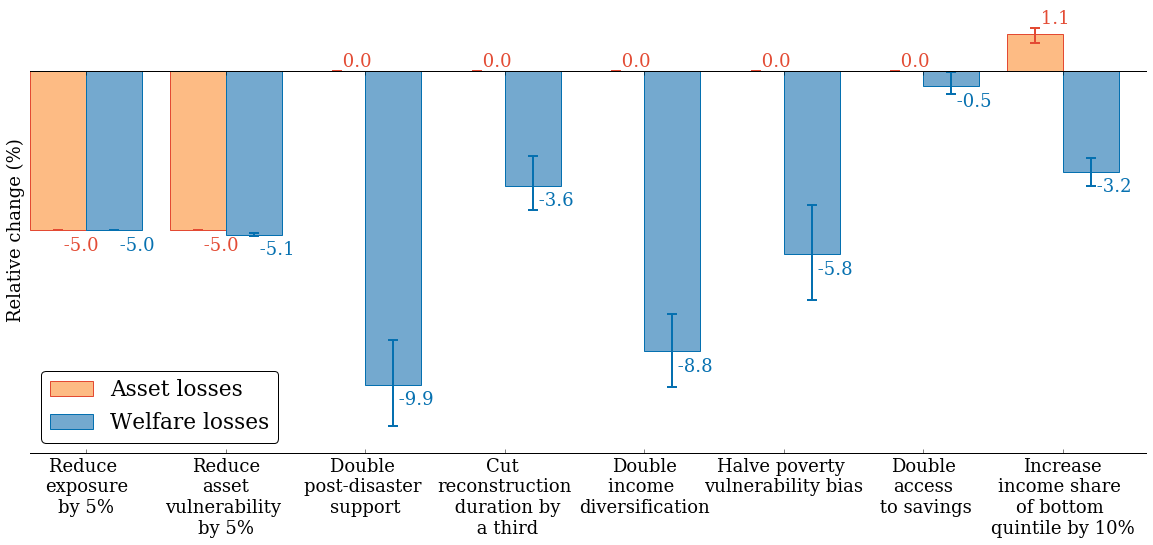

In [14]:
plot_sensiv(sensiv)
plt.savefig("img/mumbai_sensiv.png",bbox_inches="tight")

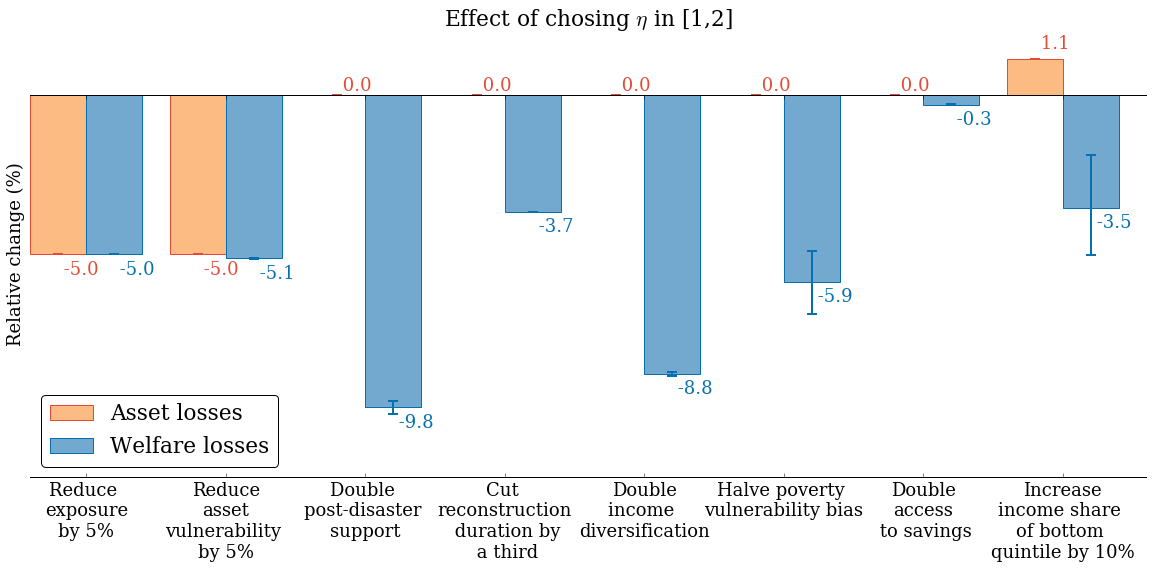

In [15]:
plot_sensiv(sensiv_eta)
plt.title("Effect of chosing $\eta$ in [1,2]")
plt.savefig("img/mumbai_sensiv_eta.png",bbox_inches="tight")

###Scatter plot to compare policies

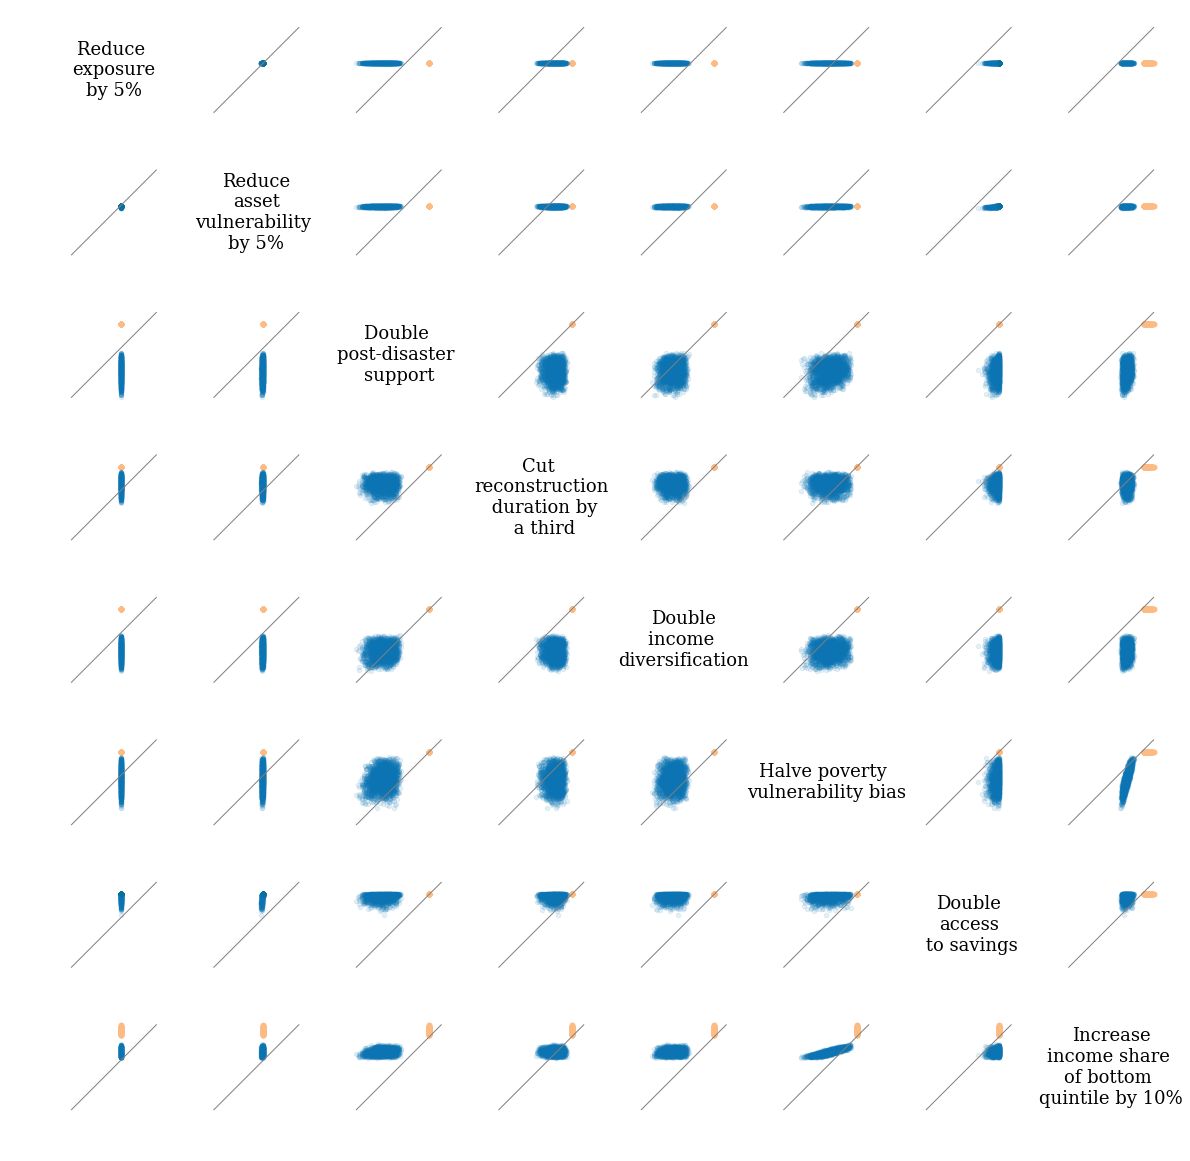

In [16]:
mins = sensiv.min().min()
maxs = sensiv.max().max()
cent = .5*(maxs+mins)

pols =['fa_.95', 'v_.95', 'double_sigma','rebuild_one_third','double_social',
       'halve_pv', 'double_banks', 'share1_ten_percent']

p=len(pols)
fig,axes = plt.subplots(p,p,figsize=(20,20),sharex=True,sharey=True)
for i in range(p):
    for j in range(p):   
        axes[i,j].axis("off")
        
        if i==j:
            axes[i,j].text(cent,cent, policy_descriptions[pols[i]],ha="center",va="center")
        else:
            #mind the trick here, axes is indexed as [line, column] while plots are drawn (x,y)
            axes[i,j].plot([mins,maxs],[mins,maxs],color="gray")
            axes[i,j].scatter(
                sensiv.xs("dKtot", axis=1, level="metric")[pols[j]],
                sensiv.xs("dKtot", axis=1, level="metric")[pols[i]],
                color =col_a, alpha=0.75,clip_on=False
            );
            axes[i,j].scatter(
                sensiv.xs("total_equivalent_cost", axis=1, level="metric")[pols[j]],
                sensiv.xs("total_equivalent_cost", axis=1, level="metric")[pols[i]],
                color=col_d,alpha=0.10,clip_on=False
            );
            
fig.savefig("img/scatter_policies_mumbai.png",bbox_inches="tight")                                          